# Gaussian Process Regression
To approximate a function

In [1]:
import numpy as np
from mpl_toolkits import mplot3d
from matplotlib import cm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, ConstantKernel as C

We will use Gaussian process regression to approximate the following function and find its global
maximum (i.e ) $y^{*} \approx 1$ at $( \left(x_{1}^{*}, x_{2}^{*}\right)=(2.25,2.65) )$

In [2]:
# function to predict
def func(x1,x2):
    return 0.5*np.exp(-0.5*((x1+1.25)**2+(x2+1.75)**2))+np.exp(-0.5*((x1-2.25)**2+(x2-2.65)**2))

In [3]:
current_max = 0
x1, x2 = 0, 0
for x_1 in np.linspace(-10,10, 500):
    for x_2 in np.linspace(-10,10, 500):
        y = func(x_1, x_2)
        if y > current_max:
            current_max = y
            x1 , x2 = x_1, x_2
            
print(f"Global Optimum: {current_max}")
print(f"Corresponding x1, x2: {x1, x2}")

Global Optimum: 0.999777024262348
Corresponding x1, x2: (2.2645290581162314, 2.6653306613226455)


Next, we define our “true” and “noisy” functions as follows:

In [4]:
def func(x1,x2):
    return 0.5*np.exp(-0.5*((x1+1.25)**2+(x2+1.75)**2))+np.exp(-0.5*((x1-2.25)**2+(x2-2.65)**2))

def noisy_func(x1,x2):
    output = func(x1,x2)
    noise = np.random.normal(0,0.1,np.shape(output))
    return output + noise

## Write code for the following acquisition functions: 

- probability of improvement: 
$$A\left(x, f^{*}\right)=P\left(f_{x}>f^{*}\right)=\Phi\left(\gamma_{x}\right)$$
- expected improvement: 
$$\mathbb{E}\left[\max \left\{f_{x}-f^{*}, 0\right\}\right]=\sigma_{x}\left[\gamma_{x} \Phi\left(\gamma_{x}\right)+\phi\left(\gamma_{x}\right)\right]$$ 
- upper confidence bound: 
$$A(x)=\mu_{x}+\kappa \sigma_{x}$$

In [5]:
# Write code for probability of improvement  
def probability_of_improvement(mu_x,sigma_x,opt_val):
    gamma = (mu_x - opt_val)/sigma_x
    return norm.cdf(gamma)
    
def expected_improvement(mu_x,sigma_x,opt_val):
    gamma = (mu_x - opt_val)/sigma_x
    return sigma_x * gamma * norm.cdf(gamma) + sigma_x * norm.pdf(gamma)

def upper_confidence_bound(mu_x,sigma_x,k):
    return mu_x + k * sigma_x

Define a query fxn using `scipy.optimize.minimize` 

In [6]:
def my_acquisition_function(mu_x, sigma_x, k):
#     return upper_confidence_bound(mu_x,sigma_x,k=1)
    return expected_improvement(mu_x,sigma_x,opt_val=1)

def query(opt_val,gp):
    def obj(x):
        #do gaussian process prediction
        mu_x,sigma_x = gp.predict(x.reshape(1,-1),return_std=True)
        
        return -my_acquisition_function(mu_x,sigma_x,opt_val)
    
    x0 = np.random.uniform(-5,5,2)
    res = minimize(obj, x0=x0.reshape(1,-1), bounds=([-5, 5], [-5, 5]))
    return res.x

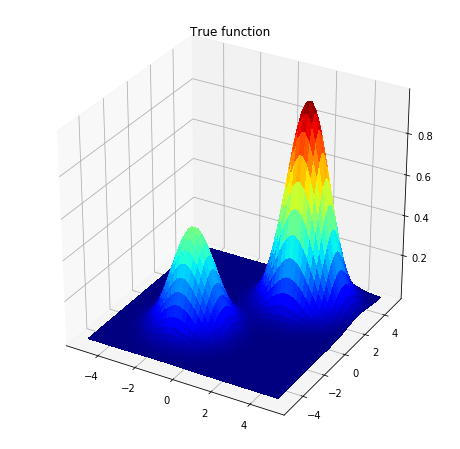

In [7]:
def add_subplot(gp, subplt):
    mu = gp.predict(meshpts, return_std=False)
    ax = fig.add_subplot(2, 5, subplt, projection = '3d')
    ax.plot_surface(meshX, meshY, np. reshape (mu, (50 , 50)) , rstride =1, cstride =1, cmap=cm. jet , linewidth=0, antialiased=False)

res = 50
lin = np.linspace(-5, 5, res)
meshX, meshY = np.meshgrid(lin, lin)
meshpts = np.vstack((meshX.flatten(), meshY.flatten())).T
true_y = func(meshX, meshY)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(meshX, meshY, true_y, rstride=1, cstride=1, cmap=cm.jet, linewidth=0, antialiased=False)
plt.title('True function')
plt.show()

Initialize the Gaussian process regressor with a kernel of your choice:

In [16]:

def run(xi_, yi_):
    xi = xi_[:]
    yi = yi_[:]
    gp = GaussianProcessRegressor(kernel=RBF(length_scale=1.0) , n_restarts_optimizer=10)   

    next_x, next_y = None, None

    for i in range(10):
        if not next_x is None and next_x.any():
            gp.fit([next_x], next_y)
        else:
            gp.fit(xi,yi)

        #find the current optimal value and its location
        opt_val = max(yi)
        opt_x = xi[np.where(yi == opt_val)]


        next_x = query(opt_val, gp)
        xi = np.append(xi, [next_x],axis=0)

        next_y = noisy_func(xi[-1][0], xi[-1][1]).reshape(1)

        yi = np.append(yi,next_y)

    return opt_val, opt_x

def run_old(xi_, yi_):
    xi = xi_[:]
    yi = yi_[:]
    gp = GaussianProcessRegressor(kernel=RBF(length_scale=1.0) , n_restarts_optimizer=10)   

    for i in range(10):
        gp.fit(xi,yi)

        #find the current optimal value and its location
        opt_val = max(yi)
        opt_x = xi[np.where(yi == opt_val)]

        next_x = query(opt_val, gp)
        xi = np.append(xi, [next_x],axis=0)

        next_y = noisy_func(xi[-1][0], xi[-1][1]).reshape(1)

        yi = np.append(yi,next_y)
    
    return opt_val, opt_x

In [17]:
xi_ = np.random.uniform(-5,5,(4,2))
yi_ = noisy_func(xi_[:,0], xi_[:,1])

def my_acquisition_function(mu_x, sigma_x, k):
#     return upper_confidence_bound(mu_x,sigma_x,k=1)
#     return expected_improvement(mu_x,sigma_x,opt_val=1)
    return probability_of_improvement(mu_x,sigma_x,opt_val=1)

result = max([run(xi_, yi_) for i in range(10)], key=lambda t: t[0])
result_old = max([run_old(xi_, yi_) for i in range(10)], key=lambda t: t[0])

print("Yustynn result")
print(result)

print("Old codde")
print(result_old)

Yustynn result
(0.9281099956634004, array([[2.75714798, 2.4711467 ]]))
Old codde
(0.763815027381218, array([[2.03001211, 3.24432587]]))


In [18]:
def my_acquisition_function(mu_x, sigma_x, k):
    return upper_confidence_bound(mu_x,sigma_x,k=1)
#     return expected_improvement(mu_x,sigma_x,opt_val=1)
#     return probability_of_improvement(mu_x,sigma_x,opt_val=1)

result = max([run(xi_, yi_) for i in range(10)], key=lambda t: t[0])
result_old = max([run_old(xi_, yi_) for i in range(10)], key=lambda t: t[0])

print("Yustynn result")
print(result)

print("Old codde")
print(result_old)

Yustynn result
(0.9607215061261521, array([[2.09609561, 2.51509025]]))
Old codde
(0.9186547465471272, array([[3.13877518, 2.61758487]]))


In [19]:
def my_acquisition_function(mu_x, sigma_x, k):
#     return upper_confidence_bound(mu_x,sigma_x,k=1)
    return expected_improvement(mu_x,sigma_x,opt_val=1)
#     return probability_of_improvement(mu_x,sigma_x,opt_val=1)

result = max([run(xi_, yi_) for i in range(10)], key=lambda t: t[0])
result_old = max([run_old(xi_, yi_) for i in range(10)], key=lambda t: t[0])

print("Yustynn result")
print(result)

print("Old codde")
print(result_old)

Yustynn result
(0.7923691512460758, array([[1.92736356, 1.69485981]]))
Old codde
(0.9720265687051824, array([[2.28087148, 2.72932321]]))


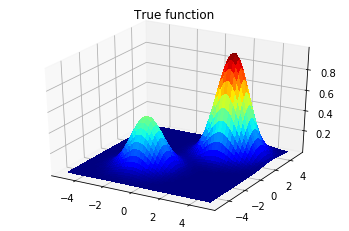

Best_value:_ 0.04197970977959607
at_ [[0.96106586 4.40787463]]
Best_value:_ 0.04197970977959607
at_ [[0.96106586 4.40787463]]
Best_value:_ 0.04197970977959607
at_ [[0.96106586 4.40787463]]
Best_value:_ 0.04197970977959607
at_ [[0.96106586 4.40787463]]
Best_value:_ 0.04197970977959607
at_ [[0.96106586 4.40787463]]
Best_value:_ 0.04197970977959607
at_ [[0.96106586 4.40787463]]
Best_value:_ 0.04197970977959607
at_ [[0.96106586 4.40787463]]
Best_value:_ 0.04197970977959607
at_ [[0.96106586 4.40787463]]
Best_value:_ 0.04197970977959607
at_ [[0.96106586 4.40787463]]
Best_value:_ 0.145747330401777
at_ [[-1.62323333  5.        ]]


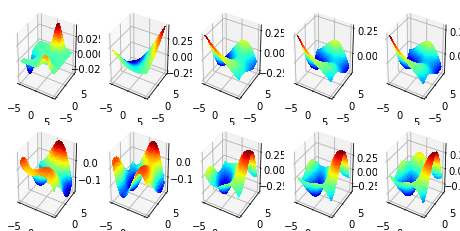

In [20]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Mar 17 20:25:45 2019

@author: YuFang
"""

import numpy as np
from mpl_toolkits import mplot3d
from matplotlib import cm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct


# Define "true" and "noisy" fxn as follows:

def func(x1,x2):
    return 0.5*np.exp(-0.5*((x1+1.25)**2+(x2+1.75)**2))+np.exp(-0.5*((x1-2.25)**2+(x2-2.65)**2))

def noisy_func(x1,x2):
    output = func(x1,x2)
    noise = np.random.normal(0,0.1,np.shape(output))
    return output + noise

# 5a)
    
# Write code for probability of improvement
    
def probability_of_improvement(mu_x,sigma_x,opt_val):
    gamma = (mu_x - opt_val)/sigma_x
    return norm.cdf(gamma)

#Write code for Expected improvement
    
def expected_improvement(mu_x,sigma_x,opt_val):
    gamma = (mu_x - opt_val)/sigma_x
    return sigma_x * gamma * norm.cdf(gamma) + sigma_x * norm.pdf(gamma)


# Write code for upper confidence bound
    
def upper_confidence_bound(mu_x,sigma_x,k):
    return mu_x + k * sigma_x

#%%

# 5b)
#define a query fxn using "scipy.optmize.minimize" 
#and the acquisition fxn of your choice

def my_acquisition_function(mu_x, sigma_x, k):
    return upper_confidence_bound(mu_x,sigma_x,k=1)


def query(opt_val,gp):
    def obj(x):
        #do gaussian process prediction
        mu_x,sigma_x = gp.predict(x.reshape(1,-1),return_std=True)
        
        return -my_acquisition_function(mu_x,sigma_x,opt_val)
    
    x0 = np.random.uniform(-5,5,2)
    res = minimize(obj, x0=x0.reshape(1,-1), bounds=([-5, 5], [-5, 5]))
    return res.x

res = 50
lin = np.linspace(-5, 5, res)
meshX, meshY = np.meshgrid(lin, lin)
meshpts = np.vstack((meshX.flatten(), meshY.flatten())).T

def add_subplot(gp, subplt):
    mu = gp.predict(meshpts, return_std=False)
    ax = fig.add_subplot(2, 5, subplt, projection = '3d')
    ax.plot_surface(meshX, meshY, np. reshape (mu, (50 , 50)) , rstride =1, cstride =1, cmap=cm. jet , linewidth=0, antialiased=False) 

true_y = func(meshX, meshY)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(meshX, meshY, true_y, rstride=1, cstride=1, cmap=cm.jet, linewidth=0, antialiased=False)
plt.title('True function')
plt.show()

fig=plt.figure(figsize=plt.figaspect(0.5))

#%%
   
# 5c)
#Complete here
   
xi=np.random.uniform(-5,5,(4,2))
yi = noisy_func(xi[:,0], xi[:,1])

#%%
   
# 5d)

#complete here
gp = GaussianProcessRegressor(kernel=RBF(length_scale=1.0))

for i in range(10):
    gp.fit(xi,yi)
    
    #find the current optimal value and its location
    opt_val = max(yi)
    opt_x = xi[np.where(yi == opt_val)]
    
    print('Best_value:_', opt_val)
    print('at_', opt_x)
    
    next_x = query(opt_val, gp)
    
    #add next_x to the list of data points   
    xi = np.append(xi, [next_x],axis=0)

    next_y = noisy_func(xi[-1][0], xi[-1][1]).reshape(1)
    
    #add next_y to the list of observations
    yi = np.append(yi,next_y)

    add_subplot(gp, i+1)

plt.show()                 




